# TP01

**Exercício 1.**

Enunciado:

Pretende-se construir o horário semanal de aulas de uma turma.
  1. Existe um conjunto de salas S classificadas em “grandes” e “pequenas”.
  2. O tempo do horário está organizado em “slots” de uma hora. O total do tempo disponível é 5 horas de manhã e 5 horas às tarde.
  3. Existe um conjunto D de disciplinas.  Cada disciplina tem um atributo d com valor 1 ou 2, que classifica a duração de cada sessão (um ou dois “slots”) , um atributo a entre 2 e 3 que define o número de sessões semanais e um atributo s entre 0 e 1 que diz se a sessão necessita de uma sala grande ou não.
  4. Existe um conjunto P de professores. Cada professor tem associado um conjunto  h das            disciplinas que está habilitado a lecionar.
  5. O horário está organizado em sessões concorrentes onde cada sessão é definido por uma disciplina desce que salas e professores verifiquem as seguintes restrições
    *   Para cada disciplina todas as aulas decorrem na mesma sala e com o mesmo professor.
    *   O número total de horas lecionadas por cada professor está num intervalo de mais ou menos 20% do número médio de horas lecionadas pela totalidade dos professores.
    *   Nenhuma sala pode ser ocupada simultaneamente por mais do que uma aula e nenhum professor pode lecionar simultaneamente mais do que uma aula.
    * Em cada disciplina, cada aula é lecionada por um professor habilitado para essa disciplina e ocorre numa sala de tamanho apropriado à disciplina.

    Use o package ortools para encontrar uma solução que verifique todas as restrições e maximize o número de partes de dia (manhãs ou tardes) que estão livres de qualquer aula.


* S - salas
* E - dia
* H - hora/slot
* D - cadeira/disciplina
* P - Professor

In [1]:
from ortools.linear_solver import pywraplp

salas_g = ["a1","a2"] # auditorios - salas grandes
salas_p = ["s1","s2","s3","s4"] # salas pequenas
dias = ["segunda","terça","quarta","quinta","sexta"]
slots_manha = 5
slots_tarde = 5
professores = ["p1","p2","p3","p4"]
disciplinas = ["d1","d2","d3","d4"]

aulas = {"d1":(2,2,1), "d2":(1,3,0), "d3":(2,3,1), "d4":(2,2,0)} # quais sao os atributos das cadeiras em formato (n de slots a ocupar, n de sessões, se precisa de sala grande-1 ou não-0)

leciona = {"p1":["d1"], "p2":["d3"], "p3":["d2"], "p4":["d4"]} # quais cadeiras os professores podem lecionar

solver = pywraplp.Solver.CreateSolver('SCIP')

horario={}
for d in disciplinas:
  for p in professores:
    for s in salas_g + salas_p:
      for dia in dias:
        for slot in range(slots_manha + slots_tarde):
          horario[d,p,s,dia,slot]= solver.IntVar(0,1,f'x[{d},{p},{s},{dia},{slot}]')

#========================
# RESTRIÇOES
#========================

# 1. Cada cadeira tem um num fixo de sesões por semana, na msm sala e com mesmo docente
for d in disciplinas:
    for p in professores:
        for s in salas_g + salas_p:
            for dia in dias:
                for slot in range(slots_manha + slots_tarde):
                    nsessoes = aulas[d][1]
                    solver.Add(solver.Sum(horario[d, p, s, dia, slot] for s in salas_g + salas_p for dia in dias for slot in range(slots_manha + slots_tarde)) == nsessoes)


# 2. O número total de horas lecionadas por cada professor é mais ou menos 20% do número médio de horas lecionadas pela totalidade dos professores.
horasprof = sum(aulas[d][0] * aulas[d][1] for d in disciplinas) / len(professores)
for p in professores:
    horas_total_aulas = solver.Sum(aulas[d][0] * aulas[d][1] * solver.Sum(horario[d, p, s, dia, slot] for s in salas_g + salas_p for dia in dias for slot in range(slots_manha + slots_tarde)) for d in disciplinas)
    solver.Add(horas_total_aulas >= 0.8 * horasprof)
    solver.Add(horas_total_aulas <= 1.2 * horasprof)


# 3. Nenhuma sala pode ser ocupada simultaneamente por mais do que uma aula e nenhum professor pode lecionar simultaneamente mais do que uma aula.
for dia in dias:
    for slot in range(slots_manha + slots_tarde):
        for s in salas_g + salas_p:
            solver.Add(solver.Sum(horario[d, p, s, dia, slot] for d in disciplinas for p in professores) <= 1)


# 4. Restrições de disponibilidade das salas de acordo com o atributo s
for d in disciplinas:
    for dia in dias:
        for slot in range(slots_manha + slots_tarde):
            if aulas[d][2] == 1:  # Requer sala grande
                solver.Add(solver.Sum(horario[d, p, s, dia, slot] for p in professores for s in salas_p) == 0)

# 5. Restrição para evitar que uma aula de 2 slots seja dividida entre manhã e tarde
for d in disciplinas:
    for p in professores:
        for s in salas_g + salas_p:
            for dia in dias:
                for slot in range(slots_manha + slots_tarde - 1):
                    # Verifique se a aula começa de manhã e termina à tarde
                    if slot < slots_manha - 1 and slot + aulas[d][0] > slots_manha:
                        solver.Add(horario[d, p, s, dia, slot] + horario[d, p, s, dia, slot + 1] <= 1)
                    # Verifique se a aula começa à tarde e termina à tarde
                    elif slot >= slots_manha and slot + aulas[d][0] > slots_manha + slots_tarde:
                        solver.Add(horario[d, p, s, dia, slot] + horario[d, p, s, dia, slot + 1] <= 1)

problema = solver.Sum(1 - solver.Sum(horario[d, p, s, dia, slot] for d in disciplinas for p in professores for s in salas_g + salas_p for dia in dias for slot in range(slots_manha + slots_tarde)) for dia in dias for slot in range(slots_manha + slots_tarde))
solver.Maximize(problema)

# Resolva o problema
status = solver.Solve()

# Verificar o status da solução
if status == pywraplp.Solver.OPTIMAL:
    print('Solução ótima encontrada:')
    for dia in dias:
        for slot in range(slots_manha + slots_tarde):
            for p in professores:
                for d in disciplinas:
                    for s in salas_g + salas_p:
                        if horario[d, p, s, dia, slot].solution_value():
                            print(f'Disciplina {d}, Professor {p}, Sala {s}')
            print()
else:
    print('O solver não conseguiu encontrar uma solução ótima. Status:', status)

O solver não conseguiu encontrar uma solução ótima. Status: 2


**Exercício 2.**


2.  Um sistema de tráfego  é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e  os arcos denotam vias de comunicação só com um sentido. O grafo tem de ser ligado: entre cada par de nodos n1, n2 tem de existir um caminho n1 a n2 e um caminho n2 a n1.
    1. Gerar aleatoriamente o grafo com  N de 8..15 nodos e com ramos verificando:
        1. Cada nodo tem um número aleatório de descendentes d de 0..3, cujos destinos são também gerados aleatoriamente. 
        2. Se  existirem “loops”  ou destinos repetidos, deve-se gerar outro grafo.
    2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

C:\Users\heych\AppData\Local\Temp\ipykernel_30904\3695980393.py:26: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  descendants = random.sample(G.nodes(), num_descendants)


DiGraph with 8 nodes and 15 edges
É possível ter 7 vias em manutenção


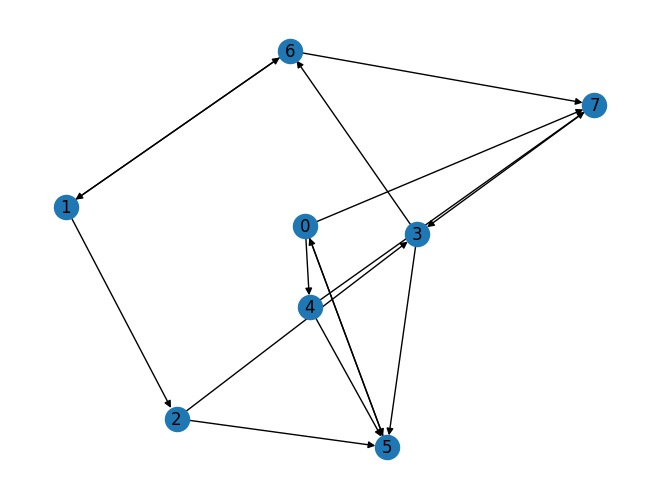

In [167]:
import networkx as nx
import random

#gerar um grafo falso so para entrar no loop
G = nx.DiGraph()
G.add_nodes_from(range(2))

#verifica se tem loops ou destinos iguais
def has_duplicate_destinations(graph):
    for node in graph.nodes():
        sucess = list(graph.successors(node))
        for s in sucess:
            new = sucess.copy()
            new.remove(s)
            if s in new:
                return True
    return False

#gera ate as condiçoes estarem satisfeitas
while (not nx.is_strongly_connected(G)) or nx.is_directed_acyclic_graph(G) or has_self_loops(G) or has_duplicate_destinations(G):
    N = random.randint(8, 15)
    G = nx.DiGraph()
    G.add_nodes_from(range(N))
    for node in G.nodes():
        num_descendants = random.randint(0, 3)
        descendants = random.sample(G.nodes(), num_descendants)
        for descendant in descendants:
            G.add_edge(node, descendant)

#funçao recursiva que verifica o maior numero de arestas que pode eliminar continuando a ser ligado
def rec(graph, lista, i, ret, j):
    if i >= len(lista):
        return ret
    elem = list(graph.successors(lista[i]))
    if j >= len(elem):
        return rec(graph, lista, i+1, ret, 0)
    GC = graph.copy()
    GC.remove_edge(lista[i], elem[j])
    if nx.is_strongly_connected(GC):
        return max(rec(graph, lista, i, ret, j+1), 
                   rec(GC, list(GC.nodes()), i, ret+1, j))
    return rec(graph, lista, i, ret, j+1)

remov = rec(G, list(G.nodes()), 0, 0, 0)

#print do grafo
print(G)
print("É possível ter", remov, "vias em manutenção")
nx.draw(G, with_labels=True)